## Carregando todas as tabelas

In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum as _sum, count, round as _round, desc, avg, stddev, min as _min, max as _max, when, datediff, to_timestamp, expr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
spark = SparkSession.builder \
    .appName("Olist-Test") \
    .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.5.1") \
    .config("spark.cassandra.connection.host", "cassandra-node1") \
    .config("spark.cassandra.connection.port", "9042") \
    .getOrCreate()

:: loading settings :: url = jar:file:/opt/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jovyan/.ivy2/cache
The jars for the packages stored in: /home/jovyan/.ivy2/jars
com.datastax.spark#spark-cassandra-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-12470992-e14f-4f96-98a1-e861c92c65d9;1.0
	confs: [default]
	found com.datastax.spark#spark-cassandra-connector_2.12;3.5.1 in central
	found com.datastax.spark#spark-cassandra-connector-driver_2.12;3.5.1 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.11.0 in central
	found org.apache.cassandra#java-driver-core-shaded;4.18.1 in central
	found com.datastax.oss#native-protocol;1.5.1 in central
	found com.datastax.oss#java-driver-shaded-guava;25.1-jre-graal-sub-1 in central
	found com.typesafe#config;1.4.1 in central
	found org.slf4j#slf4j-api;1.7.26 in central
	found io.dropwizard.metrics#metrics-core;4.1.18 in central
	found org.hdrhistogram#HdrHistogram;2.1.12 in central
	found org.reactivestreams#reactive-streams;1.0

In [4]:
df_order_customers = spark.read.format("org.apache.spark.sql.cassandra") \
    .options(table="orders_by_customer", keyspace="olist_keyspace").load()

df_order_items = spark.read.format("org.apache.spark.sql.cassandra") \
    .options(table="items_by_order", keyspace="olist_keyspace").load()

df_products = spark.read.format("org.apache.spark.sql.cassandra") \
    .options(table="products", keyspace="olist_keyspace").load()

df_sellers = spark.read.format("org.apache.spark.sql.cassandra") \
    .options(table="sellers", keyspace="olist_keyspace").load()

df_order_payments = spark.read.format("org.apache.spark.sql.cassandra") \
    .options(table="payments_by_order", keyspace="olist_keyspace").load()

df_order_reviews = spark.read.format("org.apache.spark.sql.cassandra") \
    .options(table="reviews_by_order", keyspace="olist_keyspace").load()

df_customers = spark.read.format("org.apache.spark.sql.cassandra") \
    .options(table="customers", keyspace="olist_keyspace").load()

In [7]:
df_products.show(5)

+--------------------+---------------------+--------------------------+-----------------+-----------------+-------------------+------------------+----------------+----------------+
|          product_id|product_category_name|product_description_length|product_height_cm|product_length_cm|product_name_length|product_photos_qty|product_weight_g|product_width_cm|
+--------------------+---------------------+--------------------------+-----------------+-----------------+-------------------+------------------+----------------+----------------+
|e91f53c1-42d5-52b...|     moveis_decoracao|                       216|              6.0|             40.0|                 57|                 1|          1300.0|            32.0|
|aa1e90a9-5a83-5cb...|        esporte_lazer|                      1074|             11.0|             16.0|                 58|                 5|           700.0|            11.0|
|7aa7eb75-a76c-5d2...|          eletronicos|                      3023|             16.0|      

In [10]:
df_q1 = df_order_items \
    .join(df_products, "product_id") \
    .groupBy(col("product_category_name").alias("categoria")) \
    .agg(
        _round(_sum(col("price")), 2).alias("receita_total"),
        count("order_id").alias("qtd_vendas"),
        _round(_sum(col("price")) / count("order_id"), 2).alias("ticket_medio")
    ) \
    .orderBy(desc("receita_total"))

## 1 - Quais categorias de produtos geram mais receita?

In [28]:
df_q1 = df_order_items \
    .join(df_products, "product_id") \
    .groupBy(col("product_category_name").alias("categoria")) \
    .agg(
        _round(_sum(col("price")), 2).alias("receita_total"),
        count("order_id").alias("qtd_vendas"),
        _round(_sum(col("price")) / count("order_id"), 2).alias("ticket_medio")
    ) \
    .orderBy(desc("receita_total"))

print("Top 10 Categorias por Receita:")
df_q1.show(10, truncate=False)

df_q1_pandas = df_q1.limit(10).toPandas()
df_q1.coalesce(1).write.mode("overwrite").csv("/home/jovyan/outputs/q1_categorias_receita", header=True)

Top 10 Categorias por Receita:


+----------------------+-------------+----------+------------+
|categoria             |receita_total|qtd_vendas|ticket_medio|
+----------------------+-------------+----------+------------+
|beleza_saude          |1258681.34   |9670      |130.16      |
|relogios_presentes    |1205005.68   |5991      |201.14      |
|cama_mesa_banho       |1036988.68   |11115     |93.3        |
|esporte_lazer         |988048.97    |8641      |114.34      |
|informatica_acessorios|911954.32    |7827      |116.51      |
|moveis_decoracao      |729762.49    |8334      |87.56       |
|cool_stuff            |635290.85    |3796      |167.36      |
|utilidades_domesticas |632248.66    |6964      |90.79       |
|automotivo            |592720.11    |4235      |139.96      |
|ferramentas_jardim    |485256.46    |4347      |111.63      |
+----------------------+-------------+----------+------------+
only showing top 10 rows



## 2 - Quais estados brasileiros concentram mais vendas e receita?

In [27]:
df_q2 = df_order_customers \
    .join(df_customers, "customer_id") \
    .join(df_order_items, "order_id") \
    .groupBy(col("customer_state").alias("estado")) \
    .agg(
        count("order_id").alias("qtd_pedidos"),
        _round(_sum(col("price")), 2).alias("receita_total"),
        _round(_sum(col("price")) / count("order_id"), 2).alias("ticket_medio")
    ) \
    .orderBy(desc("receita_total"))

print("Top 10 Estados por Receita:")
df_q2.show(10, truncate=False)

# Salvar resultado
df_q2_pandas = df_q2.limit(10).toPandas()
df_q2.coalesce(1).write.mode("overwrite").csv("/home/jovyan/outputs/q2_estados_vendas", header=True)

Top 10 Estados por Receita:


+------+-----------+-------------+------------+
|estado|qtd_pedidos|receita_total|ticket_medio|
+------+-----------+-------------+------------+
|SP    |47449      |5202955.05   |109.65      |
|RJ    |14579      |1824092.67   |125.12      |
|MG    |13129      |1585308.03   |120.75      |
|RS    |6235       |750304.02    |120.34      |
|PR    |5740       |683083.76    |119.0       |
|SC    |4176       |520553.34    |124.65      |
|BA    |3799       |511349.99    |134.6       |
|DF    |2406       |302603.94    |125.77      |
|GO    |2333       |294591.95    |126.27      |
|ES    |2256       |275037.31    |121.91      |
+------+-----------+-------------+------------+
only showing top 10 rows



## 3 - Qual a relação entre preço e quantidade vendida?

In [26]:
df_q3 = df_order_items \
    .withColumn("faixa_preco", 
        when(col("price") < 50, "0-50")
        .when((col("price") >= 50) & (col("price") < 100), "50-100")
        .when((col("price") >= 100) & (col("price") < 200), "100-200")
        .when((col("price") >= 200) & (col("price") < 500), "200-500")
        .otherwise("500+")
    ) \
    .groupBy("faixa_preco") \
    .agg(
        count("order_id").alias("qtd_vendas"),
        _round(avg("price"), 2).alias("preco_medio"),
        _round(_sum("price"), 2).alias("receita_total"),
        _round(_min("price"), 2).alias("preco_min"),
        _round(_max("price"), 2).alias("preco_max")
    ) \
    .orderBy("faixa_preco")

print("Vendas por Faixa de Preço:")
df_q3.show(truncate=False)

# Análise de correlação (produtos mais vendidos vs preço)
df_q3_produtos = df_order_items \
    .join(df_products, "product_id") \
    .groupBy("product_category_name") \
    .agg(
        count("order_id").alias("qtd_vendas"),
        _round(avg("price"), 2).alias("preco_medio")
    ) \
    .orderBy(desc("qtd_vendas"))

print("\nTop 10 Categorias Mais Vendidas (por quantidade):")
df_q3_produtos.show(10, truncate=False)

# Salvar resultados
df_q3_pandas = df_q3.toPandas()
df_q3.coalesce(1).write.mode("overwrite").csv("/home/jovyan/outputs/q3_preco_quantidade", header=True)
df_q3_produtos.coalesce(1).write.mode("overwrite").csv("/home/jovyan/outputs/q3_categorias_vendidas", header=True)

Vendas por Faixa de Preço:
+-----------+----------+-----------+-------------+---------+---------+
|faixa_preco|qtd_vendas|preco_medio|receita_total|preco_min|preco_max|
+-----------+----------+-----------+-------------+---------+---------+
|0-50       |39024     |31.3       |1221467.11   |0.85     |49.99    |
|100-200    |27012     |143.15     |3866693.98   |100.0    |199.99   |
|200-500    |10234     |296.2      |3031295.25   |200.0    |499.99   |
|50-100     |33141     |74.78      |2478445.78   |50.0     |99.99    |
|500+       |3239      |924.28     |2993741.59   |500.0    |6735.0   |
+-----------+----------+-----------+-------------+---------+---------+


Top 10 Categorias Mais Vendidas (por quantidade):


+----------------------+----------+-----------+
|product_category_name |qtd_vendas|preco_medio|
+----------------------+----------+-----------+
|cama_mesa_banho       |11115     |93.3       |
|beleza_saude          |9670      |130.16     |
|esporte_lazer         |8641      |114.34     |
|moveis_decoracao      |8334      |87.56      |
|informatica_acessorios|7827      |116.51     |
|utilidades_domesticas |6964      |90.79      |
|relogios_presentes    |5991      |201.14     |
|telefonia             |4545      |71.21      |
|ferramentas_jardim    |4347      |111.63     |
|automotivo            |4235      |139.96     |
+----------------------+----------+-----------+
only showing top 10 rows



## 4 - Qual o tempo médio de entrega por região?

In [25]:
df_q4 = df_order_customers \
    .filter(col("order_delivered_customer_date").isNotNull()) \
    .filter(col("order_purchase_timestamp").isNotNull()) \
    .withColumn("tempo_entrega_dias", 
        datediff(
            to_timestamp(col("order_delivered_customer_date")),
            to_timestamp(col("order_purchase_timestamp"))
        )
    ) \
    .join(df_customers, "customer_id") \
    .groupBy(col("customer_state").alias("estado")) \
    .agg(
        _round(avg("tempo_entrega_dias"), 2).alias("tempo_medio_dias"),
        _round(_min("tempo_entrega_dias"), 2).alias("tempo_min_dias"),
        _round(_max("tempo_entrega_dias"), 2).alias("tempo_max_dias"),
        count("order_id").alias("qtd_pedidos")
    ) \
    .orderBy(desc("tempo_medio_dias"))

print("Tempo Médio de Entrega por Estado:")
df_q4.show(20, truncate=False)

# Salvar resultado
df_q4_pandas = df_q4.toPandas()
df_q4.coalesce(1).write.mode("overwrite").csv("/home/jovyan/outputs/q4_tempo_entrega", header=True)

Tempo Médio de Entrega por Estado:


+------+----------------+--------------+--------------+-----------+
|estado|tempo_medio_dias|tempo_min_dias|tempo_max_dias|qtd_pedidos|
+------+----------------+--------------+--------------+-----------+
|RR    |29.34           |6             |172           |41         |
|AP    |27.18           |5             |187           |67         |
|AM    |26.36           |4             |139           |145        |
|AL    |24.5            |4             |91            |397        |
|PA    |23.73           |5             |196           |946        |
|MA    |21.51           |3             |168           |717        |
|SE    |21.46           |6             |195           |335        |
|CE    |21.2            |3             |168           |1279       |
|AC    |21.0            |7             |72            |80         |
|PB    |20.39           |6             |102           |517        |
|PI    |19.39           |2             |195           |476        |
|RO    |19.28           |8             |50      

## 5 - Quais são os métodos de pagamento predominantes em compras de alto valor?

In [24]:
df_valor_pedido = df_order_items \
    .groupBy("order_id") \
    .agg(_sum("price").alias("valor_total_pedido"))

# Calcular percentil 75 (aproximado)
percentil_75 = df_valor_pedido.approxQuantile("valor_total_pedido", [0.75], 0.01)[0]
print(f"Percentil 75 do valor dos pedidos: R$ {percentil_75:.2f}\n")

# Filtrar pedidos de alto valor e analisar métodos de pagamento
df_q5 = df_valor_pedido \
    .filter(col("valor_total_pedido") >= percentil_75) \
    .join(df_order_payments, "order_id") \
    .groupBy(col("payment_type").alias("metodo_pagamento")) \
    .agg(
        count("order_id").alias("qtd_pedidos"),
        _round(_sum("payment_value"), 2).alias("valor_total"),
        _round(avg("payment_value"), 2).alias("valor_medio"),
        _round(avg("payment_installments"), 2).alias("parcelas_media")
    ) \
    .orderBy(desc("qtd_pedidos"))

print("Métodos de Pagamento em Compras de Alto Valor:")
df_q5.show(truncate=False)

# Comparar com todos os pedidos
df_q5_todos = df_order_payments \
    .groupBy(col("payment_type").alias("metodo_pagamento")) \
    .agg(
        count("order_id").alias("qtd_pedidos"),
        _round(_sum("payment_value"), 2).alias("valor_total")
    ) \
    .orderBy(desc("qtd_pedidos"))

print("\nMétodos de Pagamento (Todos os Pedidos):")
df_q5_todos.show(truncate=False)

# Salvar resultados
df_q5_pandas = df_q5.toPandas()
df_q5.coalesce(1).write.mode("overwrite").csv("/home/jovyan/outputs/q5_pagamento_alto_valor", header=True)
df_q5_todos.coalesce(1).write.mode("overwrite").csv("/home/jovyan/outputs/q5_pagamento_todos", header=True)
print("Resultados salvos em /outputs/\n")

Percentil 75 do valor dos pedidos: R$ 149.70

Métodos de Pagamento em Compras de Alto Valor:


+----------------+-----------+-----------+-----------+--------------+
|metodo_pagamento|qtd_pedidos|valor_total|valor_medio|parcelas_media|
+----------------+-----------+-----------+-----------+--------------+
|credit_card     |20800      |7637455.36 |367.19     |5.25          |
|boleto          |4228       |1563616.09 |369.82     |1.0           |
|voucher         |1109       |154566.08  |139.37     |1.0           |
|debit_card      |316        |118537.18  |375.12     |1.0           |
+----------------+-----------+-----------+-----------+--------------+


Métodos de Pagamento (Todos os Pedidos):
+----------------+-----------+-------------+
|metodo_pagamento|qtd_pedidos|valor_total  |
+----------------+-----------+-------------+
|credit_card     |76795      |1.254208419E7|
|boleto          |19784      |2869361.27   |
|voucher         |5775       |379436.87    |
|debit_card      |1529       |217989.79    |
|not_defined     |3          |0.0          |
+----------------+-----------+-------

Resultados salvos em /outputs/



## Analise gráfica

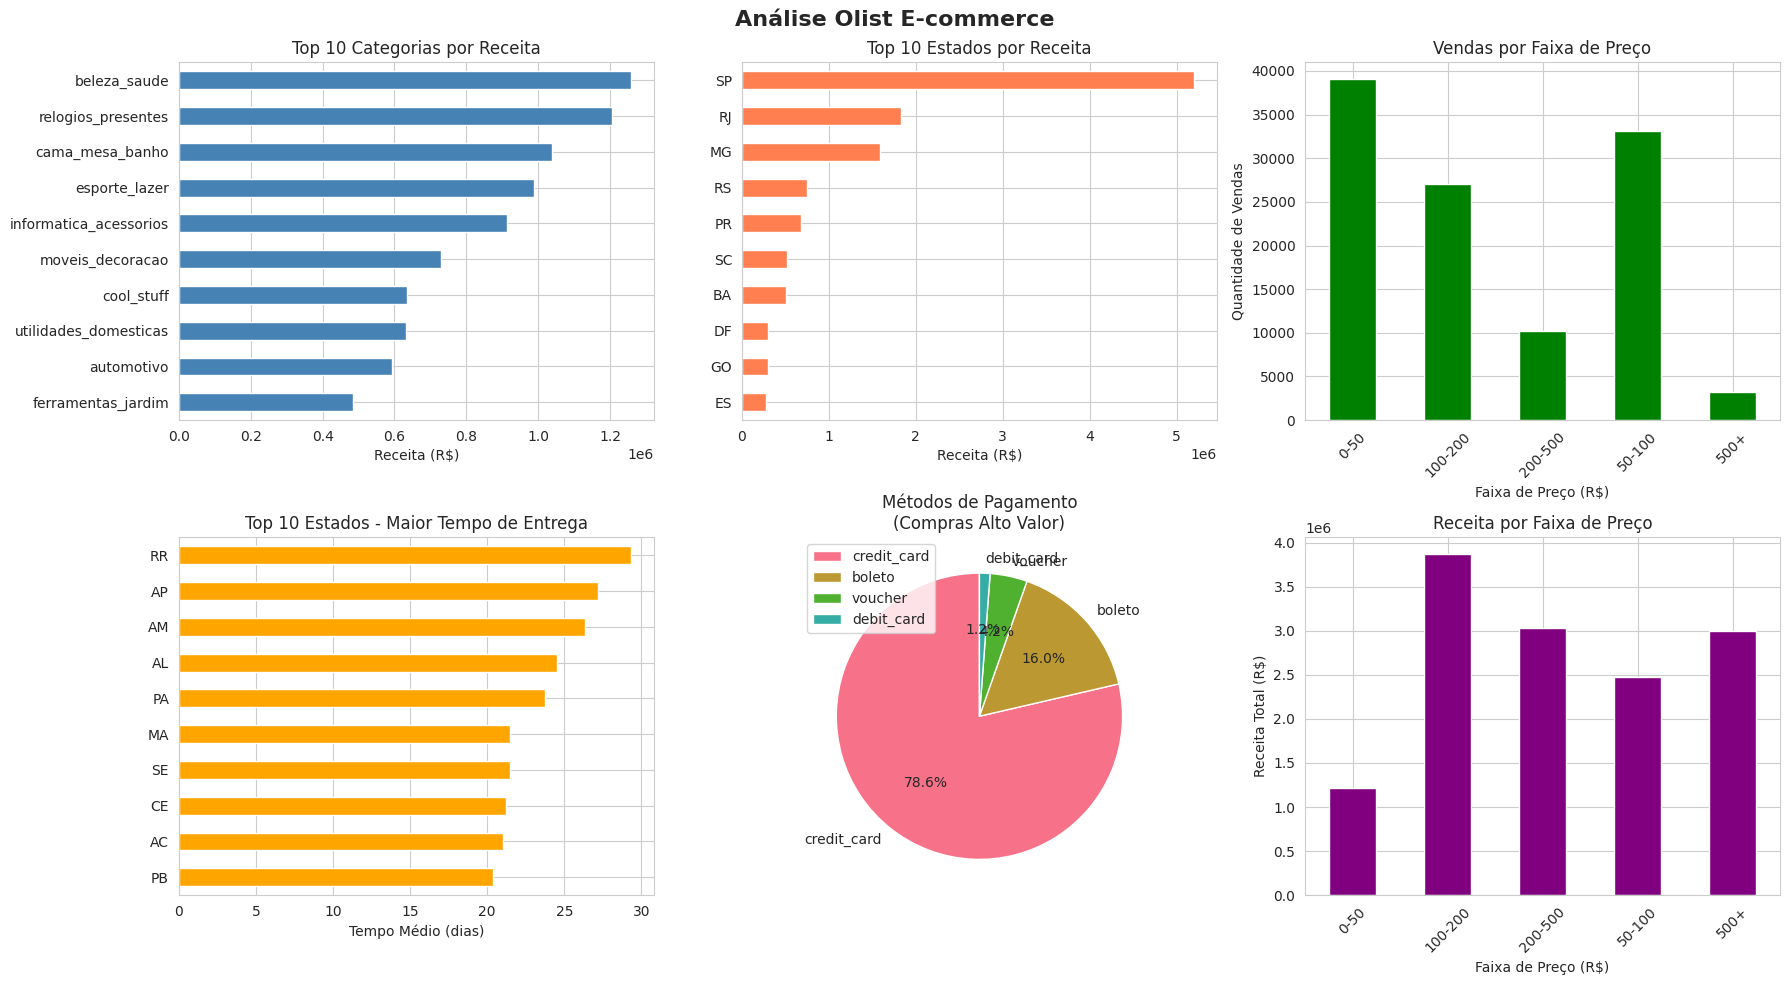

In [30]:
# Configurar estilo
sns.set_style("whitegrid")
sns.set_palette("husl")

# Criar figura com múltiplos gráficos
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Análise Olist E-commerce', fontsize=16, fontweight='bold')

# 1. Top 10 Categorias por Receita
ax1 = axes[0, 0]
df_q1_pandas.head(10).plot(kind='barh', x='categoria', y='receita_total', ax=ax1, color='steelblue', legend=False)
ax1.set_title('Top 10 Categorias por Receita')
ax1.set_xlabel('Receita (R$)')
ax1.set_ylabel('')
ax1.invert_yaxis()

# 2. Top 10 Estados por Receita
ax2 = axes[0, 1]
df_q2_pandas.head(10).plot(kind='barh', x='estado', y='receita_total', ax=ax2, color='coral', legend=False)
ax2.set_title('Top 10 Estados por Receita')
ax2.set_xlabel('Receita (R$)')
ax2.set_ylabel('')
ax2.invert_yaxis()

# 3. Vendas por Faixa de Preço
ax3 = axes[0, 2]
df_q3_pandas.plot(kind='bar', x='faixa_preco', y='qtd_vendas', ax=ax3, color='green', legend=False)
ax3.set_title('Vendas por Faixa de Preço')
ax3.set_xlabel('Faixa de Preço (R$)')
ax3.set_ylabel('Quantidade de Vendas')
ax3.tick_params(axis='x', rotation=45)

# 4. Tempo Médio de Entrega por Estado (Top 10)
ax4 = axes[1, 0]
df_q4_pandas.head(10).plot(kind='barh', x='estado', y='tempo_medio_dias', ax=ax4, color='orange', legend=False)
ax4.set_title('Top 10 Estados - Maior Tempo de Entrega')
ax4.set_xlabel('Tempo Médio (dias)')
ax4.set_ylabel('')
ax4.invert_yaxis()

# 5. Métodos de Pagamento (Alto Valor)
ax5 = axes[1, 1]
df_q5_pandas.plot(kind='pie', y='qtd_pedidos', labels=df_q5_pandas['metodo_pagamento'], ax=ax5, autopct='%1.1f%%', startangle=90)
ax5.set_title('Métodos de Pagamento\n(Compras Alto Valor)')
ax5.set_ylabel('')

# 6. Distribuição de Receita por Faixa de Preço
ax6 = axes[1, 2]
df_q3_pandas.plot(kind='bar', x='faixa_preco', y='receita_total', ax=ax6, color='purple', legend=False)
ax6.set_title('Receita por Faixa de Preço')
ax6.set_xlabel('Faixa de Preço (R$)')
ax6.set_ylabel('Receita Total (R$)')
ax6.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('/home/jovyan/outputs/dashboard_analise.png', dpi=300, bbox_inches='tight')
plt.show()